<a href="https://colab.research.google.com/github/LanceNorskog/deep-scurve/blob/master/notebooks/Scurve_MNIST_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TensorFlow 2.x selected.


<Figure size 432x288 with 0 Axes>

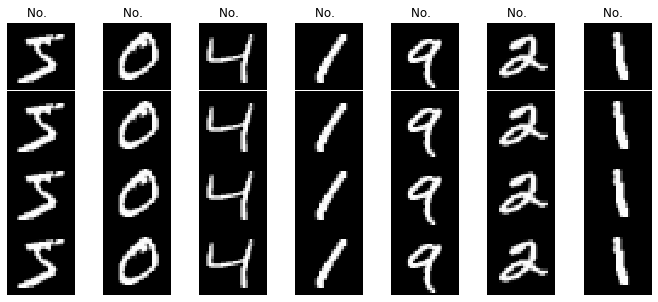

In [0]:
%tensorflow_version 2.x
!pip uninstall -y keras
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.datasets.mnist import load_data

# load the data - it returns 2 tuples of digits & labels - one for
# the train set & the other for the test set
(train_digits, train_labels), (test_digits, test_labels) = load_data()

# display 14 random images from the training set
np.random.seed(123)

# code to view the images
def display1(digits, labels):
    num_cols = len(digits)
    plt.clf()
    f, ax = plt.subplots(1, num_cols, figsize=(11,5),
                        gridspec_kw={'wspace':0.03, 'hspace':0.01}, 
                        squeeze=True)

    for c in range(num_cols):
            ax[c].axis("off")
            ax[c].imshow(digits[c], cmap='gray')
            ax[c].set_title('No. %s' % str(labels[c]))
    plt.show()
    plt.close()

def displayN(digits, labels):
    num_rows, num_cols = len(digits), len(digits[0])
    plt.clf()
    f, ax = plt.subplots(num_rows, num_cols, figsize=(12,5),
                        gridspec_kw={'wspace':0.03, 'hspace':0.01}, 
                        squeeze=True)

    for r in range(num_rows):
        for c in range(num_cols):
            ax[r,c].axis("off")
            ax[r,c].imshow(digits[r][c], cmap='gray')
            if r == 0:
                ax[r,c].set_title('No. %s' % str(labels[r][c]))
    plt.show()
    plt.close()

def display(digits, labels):
    if len(digits) > 1:
        displayN(digits, labels)
    else:
        display1(digits[0], labels[0])

train_digits = (train_digits / 255.0)
blanks = [' ',' ',' ',' ',' ',' ',' ',' ']

display([train_digits[0:7],train_digits[0:7],train_digits[0:7],train_digits[0:7]], [blanks, blanks, blanks, blanks])


/content
Cloning into 'remap_image'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 65 (delta 28), reused 50 (delta 16), pack-reused 0
Unpacking objects: 100% (65/65), done.
/content/remap_image


<Figure size 432x288 with 0 Axes>

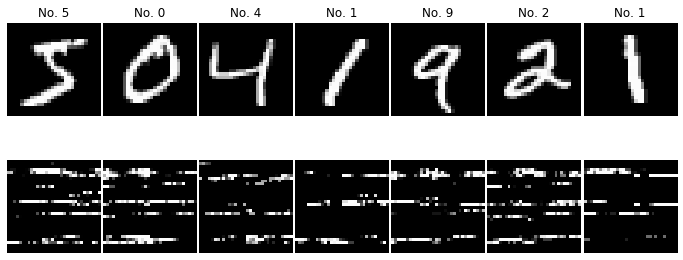

In [0]:
%cd /content
!rm -rf remap_image
!git clone https://github.com/LanceNorskog/remap_image.git
%cd /content/remap_image
import scurve.scurve as scurve
import numpy as np

side = 28
power2 = 2 ** int(np.floor(np.sqrt(28)))
map = scurve.fromSize('hilbert', 2, power2 * power2)
def get_reverse_index(index, power2):
    xy = map.point(index)
    return xy[0] * power2 + xy[1]

def pad_image(image, power2):
    padded = np_zeros((power2 * power2, power2 * power2))
    padded[0:images.shape[1]] = images[i]
    return padded

def remap(images, tiling, inverted=False):
    side = images.shape[-1]
    power2 = 2 ** int(np.floor(np.sqrt(side) + 0.49))
    if power2 == side * 2:
        power2 = side
            
    h_indexes = np.arange(0, (power2 * power2), dtype='int32')
    h_indexes_inverted = np.arange(0, (power2 * power2), dtype='int32')
    if tiling != 'flyback':
        for index in range(power2 * power2):
            h_indexes[index] = get_reverse_index(index, power2)
        for x in range(power2):
            for y in range(power2):
                h_indexes_inverted[x * side + y] = map.index([x, y])        
    tiles = np.zeros((images.shape[0], power2, power2))
    for i in range(images.shape[0]):
        padded = np.reshape(np.pad(images[i], (0, power2-side), mode='constant', constant_values=(0)), (power2*power2))
        if not inverted:
            tiles[i] = np.reshape(padded[h_indexes], (power2, power2))
        else:
            tiles[i] = np.reshape(padded[h_indexes_inverted], (power2, power2))
    return tiles

remapped_digits = remap(train_digits[0:7], 'hilbert')
display([train_digits[0:7], remapped_digits[0:7]], [train_labels[0:7], train_labels[0:7]])



In [0]:
from tensorflow.keras.models import Sequential
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train / 255.0)
x_test = (x_test / 255.0)

square=32
batchsize=32
activation='tanh'
activation2='sigmoid'
neighborhood = 1
steps = (square * square) // neighborhood
num_train=30*1024
num_test=5*1024
epochs = 20
dropout=0.2

In [0]:
def train(units, tiling):
    x_train1 = remap(x_train[0:num_train], tiling)
    x_test1 = remap(x_test[0:num_test], tiling)

    model = Sequential()
    model.add(layers.Input(shape=(x_train1.shape[1:])))
    model.add(layers.Reshape((steps, neighborhood)))
    model.add(layers.LSTM(units, activation=activation, return_sequences=True))
    model.add(layers.Dropout(dropout))
    model.add(layers.LSTM(units, activation=activation, return_sequences=True))
    model.add(layers.Dropout(dropout))
    model.add(layers.TimeDistributed(layers.Dense(neighborhood, activation=activation2)))
    model.add(layers.Reshape((square, square)))
    model.add(layers.Dropout(dropout))
    opt = tf.keras.optimizers.Adam(lr=0.0001) #, decay=1e-5)
    model.compile(loss='mse', optimizer=opt,
                metrics=['accuracy'])
    history = model.fit(x_train1, x_train1, epochs=epochs, validation_split=0.2,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)],
                        batch_size=batchsize, verbose=2)
    eval = model.evaluate(x=x_test1, y=x_test1, batch_size=256)
    return history, eval

In [0]:
def plot(data, units, tiling, extra=False):
    history = data[0]
    test = data[1]
    plt.figure()
    plt.ylim([0.0, epochs])
    plt.ylim([0.0, 0.8])

    metric_names = ['loss', 'accuracy']
    # summarize history for accuracy
    if extra:
        for m in ['loss', 'accuracy', 'val_loss']:
            plt.plot(history.history[m])
    plt.plot(history.history['val_accuracy'])
    plt.plot(np.repeat(test[1], epochs), linestyle='dashed', color='black')
    plt.title('train/test (tiling={}, units={})'.format(tiling, units))
    plt.xlabel('epoch')
    sname = []
    if extra:
        sname.append('{}={:01.3f}'.format('loss', np.min(history.history['loss'])))
        sname.append('{}={:01.3f}'.format('accuracy', np.max(history.history['accuracy'])))
        sname.append('{}={:01.3f}'.format('val_loss', np.min(history.history['val_loss'])))
    sname.append('{}={:01.3f}'.format('val_accuracy', np.max(history.history['val_accuracy'])))
    sname.append('{}={:01.3f}'.format('test_accuracy', test[1]))
    if test[1] > 0.6:
        placement = 'center right'
    else:
        placement = 'upper right'
    plt.legend(sname, loc=placement)
    plt.show()

Train on 24576 samples, validate on 6144 samples
Epoch 1/20
24576/24576 - 50s - loss: 0.2878 - accuracy: 0.0764 - val_loss: 0.2172 - val_accuracy: 0.3834
Epoch 2/20
24576/24576 - 45s - loss: 0.2542 - accuracy: 0.0718 - val_loss: 0.1818 - val_accuracy: 0.3821
Epoch 3/20
24576/24576 - 47s - loss: 0.2044 - accuracy: 0.0744 - val_loss: 0.1494 - val_accuracy: 0.3820
Epoch 4/20
24576/24576 - 48s - loss: 0.1746 - accuracy: 0.0744 - val_loss: 0.1316 - val_accuracy: 0.3812
Epoch 5/20
24576/24576 - 48s - loss: 0.1553 - accuracy: 0.0743 - val_loss: 0.1183 - val_accuracy: 0.3813
Epoch 6/20
24576/24576 - 46s - loss: 0.1403 - accuracy: 0.0747 - val_loss: 0.1077 - val_accuracy: 0.3821
Epoch 7/20
24576/24576 - 46s - loss: 0.1283 - accuracy: 0.0744 - val_loss: 0.0993 - val_accuracy: 0.3832
Epoch 8/20
24576/24576 - 47s - loss: 0.1188 - accuracy: 0.0747 - val_loss: 0.0926 - val_accuracy: 0.3831
Epoch 9/20
24576/24576 - 47s - loss: 0.1113 - accuracy: 0.0748 - val_loss: 0.0874 - val_accuracy: 0.3834
Epoch 

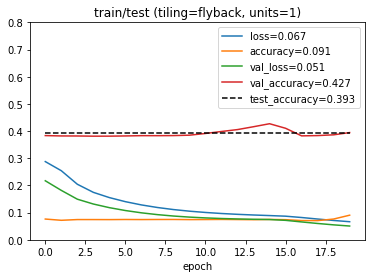

In [0]:
plot(train(1, 'flyback'), 1, 'flyback', extra=True)

Train on 24576 samples, validate on 6144 samples
Epoch 1/20
24576/24576 - 53s - loss: 0.2670 - accuracy: 0.0320 - val_loss: 0.1785 - val_accuracy: 0.2892
Epoch 2/20
24576/24576 - 47s - loss: 0.1976 - accuracy: 0.0293 - val_loss: 0.1406 - val_accuracy: 0.2758
Epoch 3/20
24576/24576 - 49s - loss: 0.1647 - accuracy: 0.0287 - val_loss: 0.1206 - val_accuracy: 0.2580
Epoch 4/20
24576/24576 - 53s - loss: 0.1419 - accuracy: 0.0348 - val_loss: 0.1022 - val_accuracy: 0.2868
Epoch 5/20
24576/24576 - 50s - loss: 0.1178 - accuracy: 0.0399 - val_loss: 0.0870 - val_accuracy: 0.2884
Epoch 6/20
24576/24576 - 50s - loss: 0.1042 - accuracy: 0.0400 - val_loss: 0.0811 - val_accuracy: 0.3796
Epoch 7/20
24576/24576 - 48s - loss: 0.0973 - accuracy: 0.0396 - val_loss: 0.0779 - val_accuracy: 0.4168
Epoch 8/20
24576/24576 - 51s - loss: 0.0928 - accuracy: 0.0415 - val_loss: 0.0762 - val_accuracy: 0.4718
Epoch 9/20
24576/24576 - 51s - loss: 0.0897 - accuracy: 0.0428 - val_loss: 0.0754 - val_accuracy: 0.4968
Epoch 

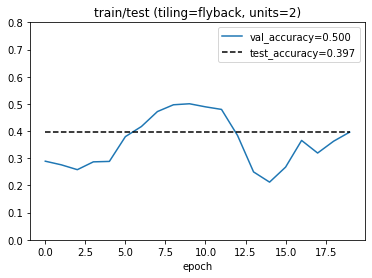

In [0]:
plot(train(2, 'flyback'), 2, 'flyback')

Train on 24576 samples, validate on 6144 samples
Epoch 1/20
24576/24576 - 53s - loss: 0.1893 - accuracy: 0.0497 - val_loss: 0.0751 - val_accuracy: 0.3796
Epoch 2/20
24576/24576 - 51s - loss: 0.0845 - accuracy: 0.0526 - val_loss: 0.0736 - val_accuracy: 0.3821
Epoch 3/20
24576/24576 - 49s - loss: 0.0813 - accuracy: 0.0511 - val_loss: 0.0710 - val_accuracy: 0.3821
Epoch 4/20
24576/24576 - 49s - loss: 0.0784 - accuracy: 0.0500 - val_loss: 0.0662 - val_accuracy: 0.3822
Epoch 5/20
24576/24576 - 50s - loss: 0.0699 - accuracy: 0.0590 - val_loss: 0.0522 - val_accuracy: 0.3611
Epoch 6/20
24576/24576 - 49s - loss: 0.0580 - accuracy: 0.0705 - val_loss: 0.0433 - val_accuracy: 0.1399
Epoch 7/20
24576/24576 - 51s - loss: 0.0525 - accuracy: 0.0772 - val_loss: 0.0392 - val_accuracy: 0.1270
Epoch 8/20
24576/24576 - 51s - loss: 0.0481 - accuracy: 0.0901 - val_loss: 0.0339 - val_accuracy: 0.1418
Epoch 9/20
24576/24576 - 50s - loss: 0.0432 - accuracy: 0.1162 - val_loss: 0.0284 - val_accuracy: 0.1843
Epoch 

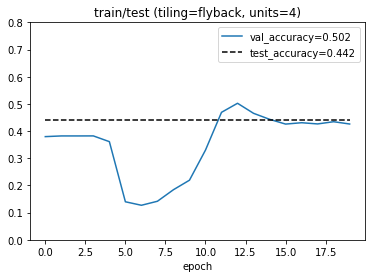

In [0]:
plot(train(4, 'flyback'), 4, 'flyback')

Train on 24576 samples, validate on 6144 samples
Epoch 1/20
24576/24576 - 55s - loss: 0.1464 - accuracy: 0.0588 - val_loss: 0.0785 - val_accuracy: 0.6822
Epoch 2/20
24576/24576 - 51s - loss: 0.0829 - accuracy: 0.0562 - val_loss: 0.0781 - val_accuracy: 0.5397
Epoch 3/20
24576/24576 - 51s - loss: 0.0818 - accuracy: 0.0568 - val_loss: 0.0765 - val_accuracy: 0.5005
Epoch 4/20
24576/24576 - 52s - loss: 0.0800 - accuracy: 0.0588 - val_loss: 0.0735 - val_accuracy: 0.4560
Epoch 5/20
24576/24576 - 51s - loss: 0.0754 - accuracy: 0.0616 - val_loss: 0.0640 - val_accuracy: 0.3908
Epoch 6/20
24576/24576 - 51s - loss: 0.0626 - accuracy: 0.0695 - val_loss: 0.0435 - val_accuracy: 0.3783
Epoch 7/20
24576/24576 - 49s - loss: 0.0469 - accuracy: 0.1093 - val_loss: 0.0273 - val_accuracy: 0.2930
Epoch 8/20
24576/24576 - 48s - loss: 0.0355 - accuracy: 0.1713 - val_loss: 0.0167 - val_accuracy: 0.3962
Epoch 9/20
24576/24576 - 47s - loss: 0.0281 - accuracy: 0.2271 - val_loss: 0.0103 - val_accuracy: 0.5983
Epoch 

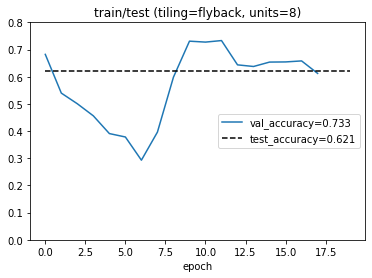

In [0]:
plot(train(8, 'flyback'), 8, 'flyback')

Train on 24576 samples, validate on 6144 samples
Epoch 1/20
24576/24576 - 52s - loss: 0.1225 - accuracy: 0.0623 - val_loss: 0.0770 - val_accuracy: 0.2157
Epoch 2/20
24576/24576 - 52s - loss: 0.0747 - accuracy: 0.0584 - val_loss: 0.0577 - val_accuracy: 0.2939
Epoch 3/20
24576/24576 - 49s - loss: 0.0501 - accuracy: 0.1107 - val_loss: 0.0304 - val_accuracy: 0.1510
Epoch 4/20
24576/24576 - 49s - loss: 0.0369 - accuracy: 0.1647 - val_loss: 0.0190 - val_accuracy: 0.1861
Epoch 5/20
24576/24576 - 49s - loss: 0.0294 - accuracy: 0.2056 - val_loss: 0.0119 - val_accuracy: 0.2804
Epoch 6/20
24576/24576 - 50s - loss: 0.0247 - accuracy: 0.2377 - val_loss: 0.0075 - val_accuracy: 0.3719
Epoch 7/20
24576/24576 - 51s - loss: 0.0222 - accuracy: 0.2588 - val_loss: 0.0053 - val_accuracy: 0.4212
Epoch 8/20
24576/24576 - 52s - loss: 0.0210 - accuracy: 0.2687 - val_loss: 0.0044 - val_accuracy: 0.4345
Epoch 9/20
24576/24576 - 52s - loss: 0.0203 - accuracy: 0.2716 - val_loss: 0.0040 - val_accuracy: 0.4393
Epoch 

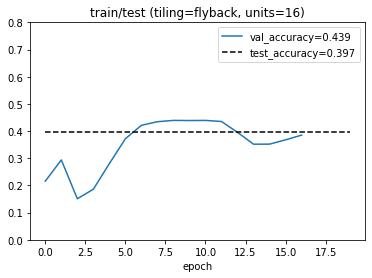

In [0]:
plot(train(16, 'flyback'), 16, 'flyback')

Train on 24576 samples, validate on 6144 samples
Epoch 1/20
24576/24576 - 53s - loss: 0.1095 - accuracy: 0.0620 - val_loss: 0.0672 - val_accuracy: 0.3832
Epoch 2/20
24576/24576 - 51s - loss: 0.0504 - accuracy: 0.1073 - val_loss: 0.0281 - val_accuracy: 0.1674
Epoch 3/20
24576/24576 - 51s - loss: 0.0313 - accuracy: 0.1915 - val_loss: 0.0117 - val_accuracy: 0.2755
Epoch 4/20
24576/24576 - 51s - loss: 0.0231 - accuracy: 0.2560 - val_loss: 0.0059 - val_accuracy: 0.4583
Epoch 5/20
24576/24576 - 49s - loss: 0.0207 - accuracy: 0.2872 - val_loss: 0.0046 - val_accuracy: 0.4856
Epoch 6/20
24576/24576 - 47s - loss: 0.0198 - accuracy: 0.2971 - val_loss: 0.0041 - val_accuracy: 0.5114
Epoch 7/20
24576/24576 - 47s - loss: 0.0193 - accuracy: 0.2925 - val_loss: 0.0040 - val_accuracy: 0.4970
Epoch 8/20
24576/24576 - 47s - loss: 0.0190 - accuracy: 0.2808 - val_loss: 0.0039 - val_accuracy: 0.4412
Epoch 9/20
24576/24576 - 50s - loss: 0.0187 - accuracy: 0.2731 - val_loss: 0.0039 - val_accuracy: 0.3638
Epoch 

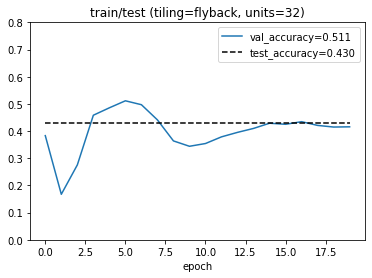

In [0]:
plot(train(32, 'flyback'), 32, 'flyback')

Train on 24576 samples, validate on 6144 samples
Epoch 1/20
24576/24576 - 50s - loss: 0.2497 - accuracy: 0.1215 - val_loss: 0.1644 - val_accuracy: 0.2472
Epoch 2/20
24576/24576 - 46s - loss: 0.1755 - accuracy: 0.1212 - val_loss: 0.1178 - val_accuracy: 0.1167
Epoch 3/20
24576/24576 - 46s - loss: 0.1420 - accuracy: 0.1218 - val_loss: 0.0997 - val_accuracy: 0.2675
Epoch 4/20
24576/24576 - 45s - loss: 0.1270 - accuracy: 0.1220 - val_loss: 0.0899 - val_accuracy: 0.3395
Epoch 5/20
24576/24576 - 47s - loss: 0.1181 - accuracy: 0.1222 - val_loss: 0.0841 - val_accuracy: 0.3426
Epoch 6/20
24576/24576 - 46s - loss: 0.1121 - accuracy: 0.1215 - val_loss: 0.0805 - val_accuracy: 0.3978
Epoch 7/20
24576/24576 - 49s - loss: 0.1077 - accuracy: 0.1217 - val_loss: 0.0782 - val_accuracy: 0.4103
Epoch 8/20
24576/24576 - 50s - loss: 0.1042 - accuracy: 0.1214 - val_loss: 0.0767 - val_accuracy: 0.4326
Epoch 9/20
24576/24576 - 49s - loss: 0.1013 - accuracy: 0.1220 - val_loss: 0.0758 - val_accuracy: 0.4546
Epoch 

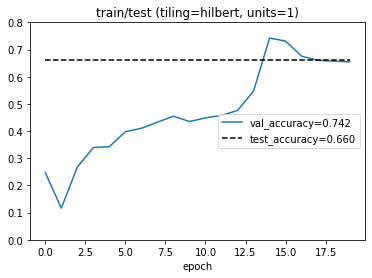

In [0]:
plot(train(1, 'hilbert'), 1, 'hilbert')

Train on 24576 samples, validate on 6144 samples
Epoch 1/20
24576/24576 - 56s - loss: 0.2660 - accuracy: 0.0587 - val_loss: 0.1693 - val_accuracy: 0.6907
Epoch 2/20
24576/24576 - 52s - loss: 0.1742 - accuracy: 0.0503 - val_loss: 0.1194 - val_accuracy: 0.7020
Epoch 3/20
24576/24576 - 53s - loss: 0.1349 - accuracy: 0.0518 - val_loss: 0.0972 - val_accuracy: 0.7000
Epoch 4/20
24576/24576 - 52s - loss: 0.1134 - accuracy: 0.0543 - val_loss: 0.0828 - val_accuracy: 0.6958
Epoch 5/20
24576/24576 - 53s - loss: 0.0996 - accuracy: 0.0538 - val_loss: 0.0738 - val_accuracy: 0.6895
Epoch 6/20
24576/24576 - 52s - loss: 0.0904 - accuracy: 0.0555 - val_loss: 0.0672 - val_accuracy: 0.6882
Epoch 7/20
24576/24576 - 52s - loss: 0.0832 - accuracy: 0.0574 - val_loss: 0.0617 - val_accuracy: 0.6896
Epoch 8/20
24576/24576 - 52s - loss: 0.0772 - accuracy: 0.0595 - val_loss: 0.0569 - val_accuracy: 0.6450
Epoch 9/20
24576/24576 - 52s - loss: 0.0717 - accuracy: 0.0633 - val_loss: 0.0522 - val_accuracy: 0.5819
Epoch 

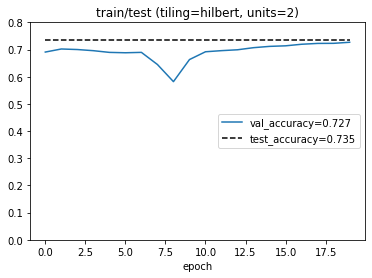

In [0]:
plot(train(2, 'hilbert'), 2, 'hilbert')

Train on 24576 samples, validate on 6144 samples
Epoch 1/20
24576/24576 - 54s - loss: 0.2086 - accuracy: 0.0470 - val_loss: 0.1007 - val_accuracy: 0.3537
Epoch 2/20
24576/24576 - 51s - loss: 0.1103 - accuracy: 0.0506 - val_loss: 0.0797 - val_accuracy: 0.4734
Epoch 3/20
24576/24576 - 49s - loss: 0.0907 - accuracy: 0.0529 - val_loss: 0.0760 - val_accuracy: 0.5394
Epoch 4/20
24576/24576 - 48s - loss: 0.0860 - accuracy: 0.0534 - val_loss: 0.0757 - val_accuracy: 0.7362
Epoch 5/20
24576/24576 - 48s - loss: 0.0843 - accuracy: 0.0542 - val_loss: 0.0756 - val_accuracy: 0.7367
Epoch 6/20
24576/24576 - 47s - loss: 0.0826 - accuracy: 0.0546 - val_loss: 0.0729 - val_accuracy: 0.7132
Epoch 7/20
24576/24576 - 49s - loss: 0.0761 - accuracy: 0.0570 - val_loss: 0.0606 - val_accuracy: 0.6754
Epoch 8/20
24576/24576 - 49s - loss: 0.0667 - accuracy: 0.0667 - val_loss: 0.0519 - val_accuracy: 0.3907
Epoch 9/20
24576/24576 - 49s - loss: 0.0592 - accuracy: 0.0775 - val_loss: 0.0450 - val_accuracy: 0.3941
Epoch 

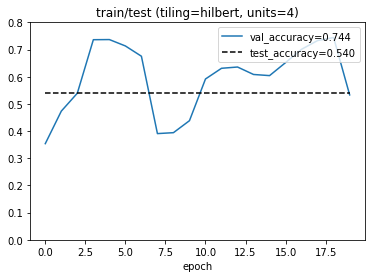

In [14]:
plot(train(4, 'hilbert'), 4, 'hilbert')

Train on 24576 samples, validate on 6144 samples
Epoch 1/20
24576/24576 - 51s - loss: 0.1667 - accuracy: 0.0538 - val_loss: 0.0777 - val_accuracy: 0.2511
Epoch 2/20
24576/24576 - 49s - loss: 0.0831 - accuracy: 0.0565 - val_loss: 0.0626 - val_accuracy: 0.6498
Epoch 3/20
24576/24576 - 49s - loss: 0.0662 - accuracy: 0.0696 - val_loss: 0.0480 - val_accuracy: 0.3483
Epoch 4/20
24576/24576 - 48s - loss: 0.0542 - accuracy: 0.0834 - val_loss: 0.0373 - val_accuracy: 0.6078
Epoch 5/20
24576/24576 - 49s - loss: 0.0449 - accuracy: 0.0971 - val_loss: 0.0271 - val_accuracy: 0.6258
Epoch 6/20
24576/24576 - 49s - loss: 0.0363 - accuracy: 0.1133 - val_loss: 0.0177 - val_accuracy: 0.6510
Epoch 7/20
24576/24576 - 52s - loss: 0.0293 - accuracy: 0.1297 - val_loss: 0.0104 - val_accuracy: 0.6897
Epoch 8/20
24576/24576 - 51s - loss: 0.0247 - accuracy: 0.1409 - val_loss: 0.0065 - val_accuracy: 0.7104
Epoch 9/20
24576/24576 - 52s - loss: 0.0224 - accuracy: 0.1469 - val_loss: 0.0047 - val_accuracy: 0.7186
Epoch 

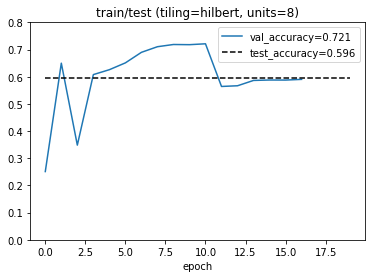

In [15]:
plot(train(8, 'hilbert'), 8, 'hilbert')

Train on 24576 samples, validate on 6144 samples
Epoch 1/20
24576/24576 - 50s - loss: 0.1183 - accuracy: 0.0597 - val_loss: 0.0637 - val_accuracy: 0.4110
Epoch 2/20
24576/24576 - 47s - loss: 0.0592 - accuracy: 0.0812 - val_loss: 0.0395 - val_accuracy: 0.6030
Epoch 3/20
24576/24576 - 49s - loss: 0.0427 - accuracy: 0.1060 - val_loss: 0.0228 - val_accuracy: 0.6285
Epoch 4/20
24576/24576 - 49s - loss: 0.0308 - accuracy: 0.1326 - val_loss: 0.0111 - val_accuracy: 0.6798
Epoch 5/20
24576/24576 - 48s - loss: 0.0238 - accuracy: 0.1498 - val_loss: 0.0059 - val_accuracy: 0.7033
Epoch 6/20
24576/24576 - 49s - loss: 0.0213 - accuracy: 0.1587 - val_loss: 0.0043 - val_accuracy: 0.7158
Epoch 7/20
24576/24576 - 50s - loss: 0.0204 - accuracy: 0.1648 - val_loss: 0.0039 - val_accuracy: 0.7367
Epoch 8/20
24576/24576 - 52s - loss: 0.0199 - accuracy: 0.1717 - val_loss: 0.0038 - val_accuracy: 0.7373
Epoch 9/20
24576/24576 - 51s - loss: 0.0196 - accuracy: 0.1756 - val_loss: 0.0038 - val_accuracy: 0.7388
Epoch 

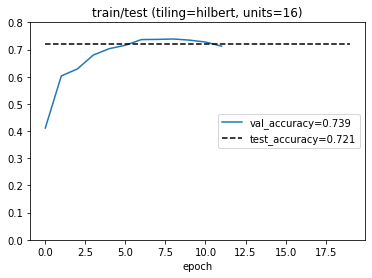

In [16]:
plot(train(16, 'hilbert'), 16, 'hilbert')

Train on 24576 samples, validate on 6144 samples
Epoch 1/20
24576/24576 - 53s - loss: 0.0954 - accuracy: 0.0771 - val_loss: 0.0416 - val_accuracy: 0.3815
Epoch 2/20
24576/24576 - 51s - loss: 0.0400 - accuracy: 0.1162 - val_loss: 0.0177 - val_accuracy: 0.4141
Epoch 3/20
24576/24576 - 50s - loss: 0.0260 - accuracy: 0.1484 - val_loss: 0.0068 - val_accuracy: 0.4214
Epoch 4/20
24576/24576 - 48s - loss: 0.0212 - accuracy: 0.1635 - val_loss: 0.0045 - val_accuracy: 0.4418
Epoch 5/20
24576/24576 - 47s - loss: 0.0201 - accuracy: 0.1747 - val_loss: 0.0040 - val_accuracy: 0.4470
Epoch 6/20
24576/24576 - 47s - loss: 0.0195 - accuracy: 0.1843 - val_loss: 0.0039 - val_accuracy: 0.4868
Epoch 7/20
24576/24576 - 47s - loss: 0.0192 - accuracy: 0.1896 - val_loss: 0.0038 - val_accuracy: 0.4696
Epoch 8/20
24576/24576 - 48s - loss: 0.0189 - accuracy: 0.1901 - val_loss: 0.0039 - val_accuracy: 0.4700
Epoch 9/20
24576/24576 - 49s - loss: 0.0186 - accuracy: 0.1875 - val_loss: 0.0039 - val_accuracy: 0.5210
Epoch 

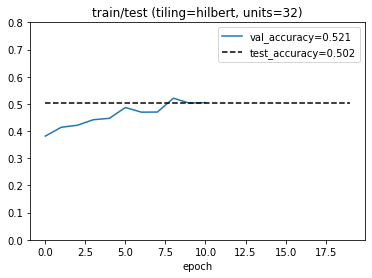

In [17]:
plot(train(32, 'hilbert'), 32, 'hilbert')

NameError: ignored

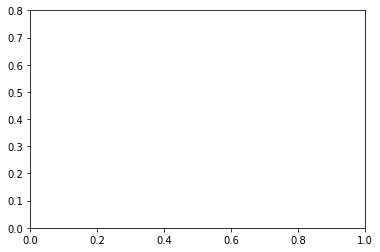

In [18]:
plt.figure()
plt.ylim([0.0, 0.8])

metric_names = ['loss', 'accuracy']
if history != None:
  # summarize history for accuracy
  for m in metric_names:
      plt.plot(history.history[m])
  for m in metric_names:
      plt.plot(history.history['val_' + m])
  plt.title('train/val (tiling={}, units={})'.format(tiling, units))
  plt.xlabel('epoch')
  sname = []
  for m in metric_names:
      sname.append('{}={:01.3f}'.format(m, history.history['val_' + m][-1]))
  plt.legend(sname, loc='center right')
  plt.show()

In [0]:
x_val = x_test[num_test:num_test*3]
y_val = y_test[num_test:num_test*3]

x_val1 = remap(x_val, tiling)
model.evaluate(x=x_val1, y=x_val1, batch_size=32)


In [0]:
vid = x_test[0:7]
labels = y_test[0:7]
vid1 = remap(vid, tiling=tiling)
pred1 = model.predict(vid1, batch_size=1)
pred2 = remap(pred1, tiling=tiling, inverted=True)


In [0]:
blanks = ['','','','','','','','']
#display([vid, vid1, pred1, pred2], [labels, blanks, blanks, blanks])


In [0]:
blanks = ['','','','','','','','']
display([vid, pred2], [labels, blanks])


In [0]:
def identity(mat):
    indexes = np.arange(0, mat.shape[0])
    mat[indexes, indexes] = 1
idmat = np.zeros((1024, 1024), dtype='float32')
identity(idmat)
ident_images = np.reshape(idmat, (1024, 32, 32))
#print(ident_images[0])
#print(ident_images[1023])

In [0]:
id_pred = model.predict(ident_images, batch_size=1024)
id_invert = remap(id_pred, tiling=tiling, inverted=True)


In [0]:
def sum_images(images):
    summed = np.zeros((1024, 32, 32), dtype='float32')
    for i in range(1024):
        for j in range(8):
            if i + j < 1024:
                summed[i] += images[i + j]
            gray = np.max(summed[i])
            if not math.isnan(gray):
                summed[i] = summed[i] / gray
    return summed

summed_ident = sum_images(ident_images)
summed_pred = sum_images(id_pred)
summed_invert = sum_images(id_invert)

display([summed_ident[200:208], summed_pred[200:208], summed_invert[200:208]], [blanks, blanks, blanks])


In [0]:
!rm -rf images/
!mkdir -p images
import imageio
from google.colab import files
import os


In [0]:
format='PNG-PIL'
png_dir = 'images/'
def animate(images, movie_file):
    for i in range(len(images)):
        imageio.imwrite(png_dir + '{:04d}.png'.format(i), images[i], format=format)

    file_names = []
    images = []
    for file_name in os.listdir(png_dir):
        if file_name.lower().endswith('.png'):
            file_names.append(file_name)
        else:
            print('??', file_name)

    file_names.sort()
    print('Found {} files'.format(len(file_names)))
    for file_name in file_names:
            file_path = os.path.join(png_dir, file_name)
            images.append(imageio.imread(file_path))


    imageio.mimsave(movie_file, images, fps=2)

frames = np.zeros(summed_invert.shape, dtype='uint8')
for i in range(frames.shape[0]):
    frames[i] = summed_invert[i] * 255
animate(frames, 'movie.gif')


In [0]:
!ls
files.download('movie.gif')